# Transmission

In [8]:
%matplotlib inline
import numpy as np
from scipy import signal
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

First, let's set up a traditional, full-precision modulator and plot the spectrum of that as a baseline

In [78]:
def prbs(n=0, taps=[]):
    state = [1]*n
    shift = lambda s: [sum([s[i] for i in taps]) % 2] + s[0:-1]
    out = []
    for i in range(2**n - 1):
        out.append(state[-1])
        state = shift(state)
    return out
prbs9 = lambda: prbs(n=9, taps=[4,8])

def make_carrier(freq=None, sample_rate=None, samples=None, phase=0):
  t = (1/sample_rate)*np.arange(samples)
  return np.real(np.exp(1j*(2*np.pi*freq*t - phase)))

def modulate_gmsk(bits, carrier_freq=2.402e9, sample_rate=5e9, baseband=False):
    symbol_rate = 1e6 # 1Mhz
    BT = 0.5
    bw = symbol_rate*BT/sample_rate

    samples_per_symbol = int(sample_rate/symbol_rate)
    
    # This looks scary but it's just a traditional gaussian distribution from wikipedia
    kernel = np.array([(np.sqrt(2*np.pi/np.log(2))*bw)*np.exp(-(2/np.log(2))*np.power(np.pi*t*bw, 2)) for t in range(-5000,5000)])
    kernel /= sum(kernel) # Normalize so things amplitude after convolution remains the same
    
    rotation = np.repeat(bits, sample_rate/symbol_rate)*2.0 - 1.0
    smoothed_rotation = np.convolve(rotation, kernel,mode='same')

    angle_per_sample = (np.pi/2.0)/(samples_per_symbol)
    current_angle = 0
    modulated = np.zeros((len(smoothed_rotation),), dtype=np.complex64) # Represents I and Q as a complex number
    i = 0
    for bit in smoothed_rotation:
      current_angle += angle_per_sample*bit
      modulated[i] = np.exp(1j*current_angle)
      i += 1

    if baseband:
        return modulated
    
    I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=0)
    Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=np.pi/2)

    return np.real(modulated)*I + np.imag(modulated)*Q

Now let's look at the FFT of this...

(-40.0, 0.0)

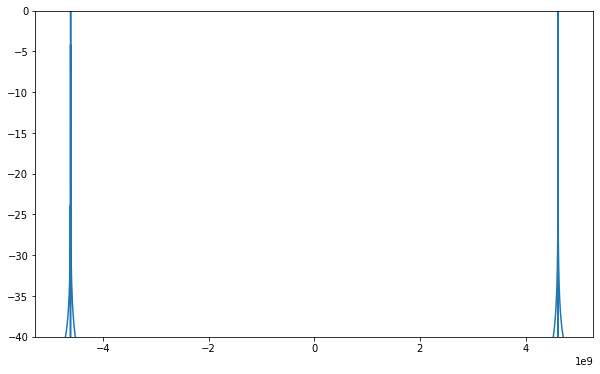

In [54]:
modulated = modulate_gmsk(prbs9(), sample_rate=5e9)

fftm = np.abs(fft(modulated))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

This is clean (as one would expect), now let's see what happens if we reduce things to 1-bit of precision by just rounding

# The Naive Approach (Rounding)

(-40.0, 0.0)

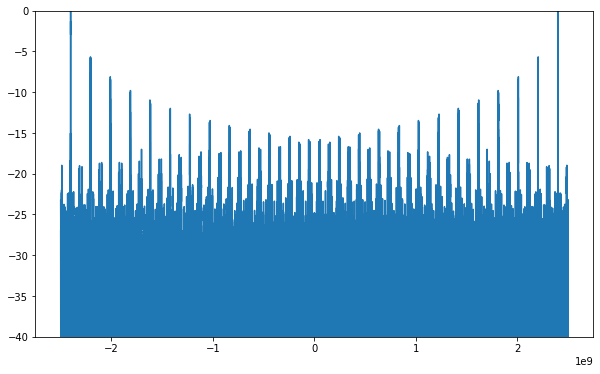

In [68]:
modulates5 = modulated = modulate_gmsk(prbs9(), sample_rate=5e9)

sample_rate=5e9

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

_Oof_ this is not pretty. What's happening here is that (I think) the aliases are mixing with each other to produce these interference paterns. In this case, it looks like the big subharmonics are spaced about 200Mhz which makes sense given the alias of 2.402ghz at 2.698ghz when sampling at 2.5ghz.

(-40.0, 0.0)

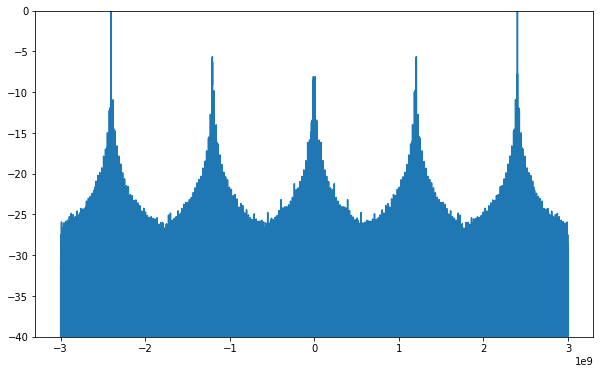

In [56]:
sample_rate = 6e9

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

Ok, in this case, the alias is at `3 + (3 - 2.402) = 3.6ghz`. The difference between this and 2.402ghz is about 1.2ghz, which looking at the next big peak, looks to be about 1.2ghz, so this makes sense. From this math, we can intuit that it's a good idea for the sample rate to be a whole number multiple of the carrier frequency. In the ideal case, 4 times the carrier:

(-40.0, 0.0)

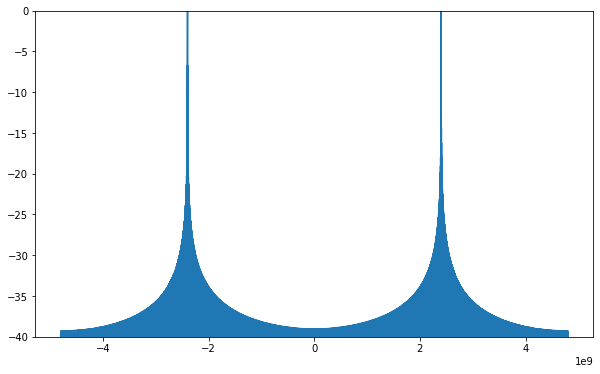

In [57]:
sample_rate = 2.402e9*4

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

There a couple of challenges here, however:

1. In order to get the clean(ish) spectrum, we have to clock the output frequency at a rate relative to the carrier frequency. If we only intended to use one frequency, this would be fine but Bluetooth (as an example) hops around frequency constantly by design. This might be doable, but it's kind of painful (this might require various SERDES resets which aren't instantaneous)
2. At 2.402ghz, 4x this would be... 9.6ghz, which is too fast for my (low-end-ish) SERDES which maxes out around 6ghz.

# Delta Sigma Modulation

A way around this is to use something called Delta Sigma Modulation. The way to think about this conceptually is that we keep a running sum of values we've output (think of this as the error) and factor this into the value we decide to output (versus just blindly rounding the current value)

In [61]:
def pwm2(sig, k=1.0):
  z1 = 0.0
  z2 = 0.0
  out = np.zeros((len(sig,)))

  for i in range(len(sig)):
    v = sig[i] - (k*z1 + z2)
    out[i] = np.sign(v)
    z2 = z1
    z1 = v - out[i]

  return out

To be clear, `pwm2` is replacing `np.sign`

(-40.0, 0.0)

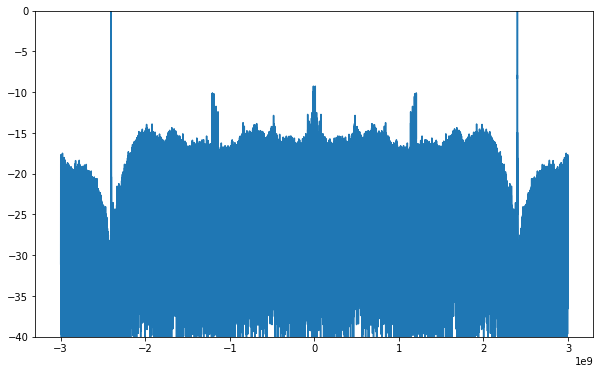

In [81]:
sample_rate = 6e9

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)
modulatedsd5 = modulated = pwm2(modulated, k=-2.0*np.cos(2.0*np.pi*2.402e9/sample_rate))

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

(2000000000.0, 2500000000.0)

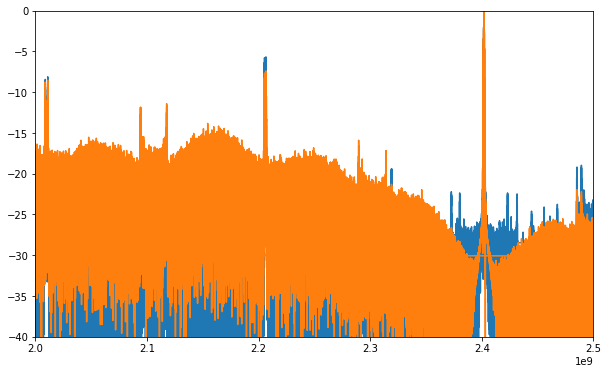

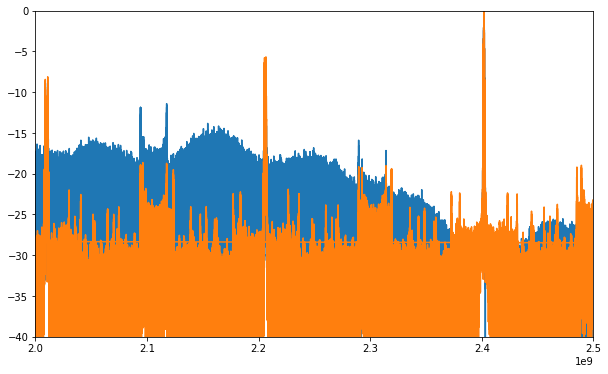

In [74]:
fftm = np.abs(fft(np.sign(modulates5)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulates5), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))

fftm = np.abs(fft(np.sign(modulatedsd5)))
fftm = fftm/np.max(fftm)

plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(2e9, 2.5e9)

plt.figure(figsize=(10,6))

fftm = np.abs(fft(np.sign(modulatedsd5)))
fftm = fftm/np.max(fftm)

plt.plot(fftbins, 10*np.log10(fftm))

fftm = np.abs(fft(np.sign(modulates5)))
fftm = fftm/np.max(fftm)

plt.plot(fftbins, 10*np.log10(fftm))

plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(2e9, 2.5e9)

# PWM Modulation

In [ ]:
def pwm_modulate(baseband):
    # First we need to decimate the baseband
    mix_frequency = carrier_freq*4
    pwm_depth = 64
    downsample = int(pwm_depth*sample_rate/mix_frequency)
    bb_down = baseband[::downsample]

    # Now let's make a mapping of PWM words
    rng = np.random.default_rng(seed=0)
    pwm_map = []
    for i in range(pwm_depth):
      pulses = np.concatenate((np.ones(i), np.zeros(pwm_depth-i)))
      #rng.shuffle(pulses) This trades off quantization bandwidth with SNR
      pwm_map.append(pulses)

    # Now convert the BB to PWM (for each IQ)
    pwm_i = []
    pwm_q = []
    for sample in bb_down:
      pwm_i.append(pwm_map[int(np.clip(pwm_depth*(np.real(sample) + 1.0)/2.0, 0, pwm_depth - 1))])
      pwm_q.append(pwm_map[int(np.clip(pwm_depth*(np.imag(sample) + 1.0)/2.0, 0, pwm_depth - 1))])
    pwm_i = np.array(pwm_i).flatten()
    pwm_q = np.array(pwm_q).flatten()

    # The I/Q carrers at the mix frequency
    in_phase = [1, 0, -1, 0]
    quad_phase = [0, 1, 0, -1]

    # Mix onto the carrier
    pwm_carrier = np.zeros((len(pwm_i),))
    m = 0
    for n in range(len(pwm_i)):
      i = pwm_i[n]
      q = pwm_q[n]
      pwm_carrier[n] = (2*i - 1)*in_phase[m%4] + (2*q - 1)*quad_phase[m%4]
      m += 1

    # Upsample to the sample rate used elsewhere
    # Note: figure out how to go from a fractional number (i.e. 2.5) to a fraction
    # we can use for up and own sampling
    pwm_carrier = signal.resample_poly(pwm_carrier, 5, 2)
    return ppwm_carrier

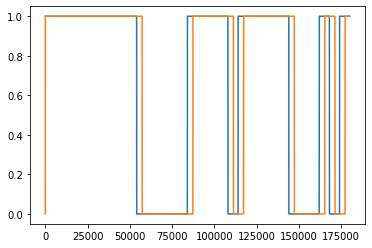

In [44]:
def demodulate_gmsk(sig, sample_rate=None):
    carrier_freq=2.402e9
    
    I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(sig), phase=0)
    Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(sig), phase=np.pi/2)

    # Mix down to (complex) baseband
    down = sig*I + 1j*sig*Q

    # Create a low pass filter at the symbol rate
    sos = signal.butter(5, symbol_rate, 'low', fs=sample_rate, output='sos')
    filtered_down = signal.sosfilt(sos, down)

    # Take the phase angle of the baseband
    angle = np.unwrap(np.angle(filtered_down))

    # Take the derivative of the phase angle and hard limit it to 1:-1
    return (np.sign(angle[1:] - angle[:-1]) + 1.0)/2.0

# Generate sample bits and plot them
sample = prbs9()[:30]
plt.plot(np.repeat(sample, sample_rate/symbol_rate))
    
# Plot the recovered bits. Note that because of the filtering the data is shifted some number of samples
plt.plot(demodulate_gmsk(modulate_gmsk(prbs9()[:30], sample_rate=sample_rate), sample_rate=sample_rate))